In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, BatchNorm2d, Linear
import torchvision
from unicodedata import normalize
from torch.utils.data import Dataset
import glob
import IPython

In [2]:
NUMBER_EPOCHS = 40
HANGEUL_EPOCHS = 20

In [3]:
#한글로 시작하는 파일은 모두 삭제
ROOT_PATH = "./data"
for i in os.listdir(ROOT_PATH):
    if not i[0].isdigit():
        os.remove(os.path.join(ROOT_PATH, i))
    

In [4]:
#파일명에 한글이 들어가서 사진을 읽을 때 이 함수로 읽는다
def my_cv_read(filepath):
    ff = np.fromfile(filepath, dtype = np.uint8)
    gray_img = cv2.imdecode(ff, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return im_bw

In [5]:
#신식 번호판인지 구식 번호판인지 분류하는 함수
def version_classifier(image):
    if image[10,10] ==0:
        #옛날 번호판
        return 0
    else:
        #신식 번호판
        return 1

In [6]:
#숫자 모델
class conv_block(torch.nn.Module):
    def __init__(self, in_channels,out_channels, kernel_size = 3,stride = 1, padding = 1, pool_width = 2):
        super(conv_block, self).__init__()
        model = []
        model.append(Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding))
        model.append(BatchNorm2d(out_channels))
        model.append(ReLU())
        model.append(MaxPool2d((pool_width, pool_width)))
        self.model = Sequential(*model)
        
    def forward(self, input_):
        return self.model(input_)
    
    
class number_classifier(torch.nn.Module):
    def __init__(self):
        super(number_classifier, self).__init__()
        self.block1 = conv_block(1, 16)
        self.block2 = conv_block(16, 32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64,128)
        self.block5 = conv_block(128,256)
        self.fc = Linear(128*2*2, 10)
        
    def features(self, input_):
        x = self.block1(input_)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x
    
    def logits(self, features):
        return self.fc(features)
    
    def forward(self, input_):
        x = self.features(input_)
        x = x.reshape(x.shape[0], -1)
        return self.logits(x)
    
class hangeul_classifier(torch.nn.Module):
    def __init__(self):
        super(hangeul_classifier, self).__init__()
        self.block1 = conv_block(1, 16)
        self.block2 = conv_block(16,32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64,128)
        self.fc = Linear(128*2*2,40)
        
    def features(self, input_):
        x= self.block1(input_)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x
    
    def logits(self, features):
        return self.fc(features)
    
    def forward(self, input_):
        x = self.features(input_)
        x = x.reshape(x.shape[0], -1)
        return self.logits(x)


In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root = "./", download = True, train=True, transform=transform)
test_data = torchvision.datasets.MNIST(root = "./", download = True, train = False, transform=transform)

In [8]:
train_loader =torch.utils.data.DataLoader(train_data, batch_size = 512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 512, shuffle=False)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
number_model = number_classifier()
number_model.to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(number_model.parameters())

In [10]:
#MNIST로 훈련시킨 모델
for i in range(NUMBER_EPOCHS):
    for image, label in train_loader:
        X_train = image.to(device)
        y_train = label.to(device)
        optimizer.zero_grad()
        y_pred = number_model(X_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print("epoch : {}".format(i))

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19
epoch : 20
epoch : 21
epoch : 22
epoch : 23
epoch : 24
epoch : 25
epoch : 26
epoch : 27
epoch : 28
epoch : 29
epoch : 30
epoch : 31
epoch : 32
epoch : 33
epoch : 34
epoch : 35
epoch : 36
epoch : 37
epoch : 38
epoch : 39


In [11]:
number_model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for image, label in test_loader:
        X_test =image.to(device)
        y_test = label.to(device)

        output  = number_model(X_test)
        _, output_idx = torch.max(output, 1)
        total += output.shape[0]
        correct += (output_idx == y_test).sum().float()
    print("accuracy : {}".format(100 * correct / total))
        

accuracy : 99.39999389648438


# 이미지 crop & 숫자 처리

In [12]:
#버전에 맞게 이미지 자르는 함수
def crop_image(img):
    version = version_classifier(img)
    if version ==0:
        print("옛날 번호판")
        img = img/ 255.0
        n1 = img[0:21, 50:87] 
        n2 = img[0:21, 87 : 112] 
        n3 = img[20:67, 3:50] 
        n4 = img[20:67, 50:100]
        n5 = img[20:67, 100:150] 
        n6 = img[20:67, 150:194] 
        char = img[2:22, 112:150]
        
    else:
        print("신식 번호판")
        img = img / 255.0
        img = (1-img)
        n1 = img[10:63,12:40]
        n2 = img[10:63, 40:60]
        n3 = img[10:63, 95:120] 
        n4 = img[10:63, 120:140]
        n5 = img[10:63, 149:163] 
        n6 = img[10:63, 163:187]
        char = img[10:63, 62:87] 
    #     plt.imshow(n1)
    #     plt.show()
    #     plt.imshow(n2)
    #     plt.show()
    #     plt.imshow(n3)
    #     plt.show()
    #     plt.imshow(n4)
    #     plt.show()
    #     plt.imshow(n5)
    #     plt.show()
    #     plt.imshow(n6)
    #     plt.show()
    #     plt.imshow(char)
    #     plt.show()
    return (n1,n2,n3,n4,n5,n6,char)

# 한글 분류

In [13]:
#한글 파일 imwrite에러를 방지한 코드
def my_imwrite(filename, img, params=None): 
    try: 
        ext = os.path.splitext(filename)[1]
        result, n = cv2.imencode(ext, img, params)
        if result: 
            with open(filename, mode='w+b') as f: 
                n.tofile(f) 
                return True 
        else: 
            return False 
    except Exception as e: 
        print(e) 
        return False

In [14]:
#한글만 자른 파일 만들기
HANGEUL_PATH = "./cropped_hangeul"
if not os.path.isdir(HANGEUL_PATH):
    os.mkdir(HANGEUL_PATH)
if not os.path.isdir(os.path.join(HANGEUL_PATH, "train")):
    os.mkdir(os.path.join(HANGEUL_PATH, "train"))
if not os.path.isdir(os.path.join(HANGEUL_PATH, "test")):
    os.mkdir(os.path.join(HANGEUL_PATH, "test"))

In [15]:
#한글 이미지만 뽑아서 분류후 폴더별로 저장
for file_name in os.listdir(ROOT_PATH):
    file_path = os.path.join(ROOT_PATH, file_name)
    img = my_cv_read(file_path)
    new_file_name = normalize("NFC", file_name)
    hangeul_char = new_file_name[2]
    hangeul_image = crop_image(img)[-1]
    #test폴더에 집어넣기
    if np.random.randint(0,100) % 10 == 0:
        if not os.path.isdir(os.path.join(HANGEUL_PATH,"test", hangeul_char)):
            os.mkdir(os.path.join(HANGEUL_PATH,"test", hangeul_char))
        my_imwrite(os.path.join(HANGEUL_PATH,"test",  hangeul_char, file_name), hangeul_image)
    #train폴더에 집어넣기
    else:
        if not os.path.isdir(os.path.join(HANGEUL_PATH , "train", hangeul_char)):
            os.mkdir(os.path.join(HANGEUL_PATH, "train", hangeul_char))
        my_imwrite(os.path.join(HANGEUL_PATH, "train", hangeul_char,file_name), hangeul_image)
IPython.display.clear_output()

In [16]:
#한글 분류하는 모델저장
class conv_block(torch.nn.Module):
    def __init__(self, in_channels,out_channels, kernel_size = 3,stride = 1, padding = 1, pool_width = 2):
        super(conv_block, self).__init__()
        model = []
        model.append(Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, padding = padding))
        model.append(BatchNorm2d(out_channels))
        model.append(ReLU())
        model.append(MaxPool2d((pool_width, pool_width)))
        self.model = Sequential(*model)
        
    def forward(self, input_):
        return self.model(input_)
    
    
class hangeul_classifier(torch.nn.Module):
    def __init__(self):
        super(number_classifier, self).__init__()
        self.block1 = conv_block(1, 16)
        self.block2 = conv_block(16, 32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64,128)
        self.block5 = conv_block(128,256)
        self.fc = Linear(128*2*2, 34)
        
    def features(self, input_):
        x = self.block1(input_)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x
    
    def logits(self, features):
        return self.fc(features)
    
    def forward(self, input_):
        x = self.features(input_)
        x = x.reshape(x.shape[0], -1)
        return self.logits(x)
    
class hangeul_classifier(torch.nn.Module):
    def __init__(self):
        super(hangeul_classifier, self).__init__()
        self.block1 = conv_block(1, 16)
        self.block2 = conv_block(16,32)
        self.block3 = conv_block(32, 64)
        self.block4 = conv_block(64,128)
        self.fc = Linear(128*2*2,40)
        
    def features(self, input_):
        x= self.block1(input_)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x
    
    def logits(self, features):
        return self.fc(features)
    
    def forward(self, input_):
        x = self.features(input_)
        x = x.reshape(x.shape[0], -1)
        return self.logits(x)


In [17]:
#resize한 한글 이미지를 새로저장
NEW_HANGEUL_PATH = "./new_cropped_hangeul"
HANGEUL_PATH = "./cropped_hangeul"
new_list = glob.glob(HANGEUL_PATH + "/train/" + "/*/" + "*")
if not os.path.isdir(NEW_HANGEUL_PATH):
    os.mkdir(NEW_HANGEUL_PATH)
for i in new_list:
    new_img = my_cv_read(i)
    new_img = cv2.resize(new_img, (32,32))
    new_char = i[-9]
    if not os.path.isdir(os.path.join(NEW_HANGEUL_PATH, "train", new_char)):
        os.makedirs(os.path.join(NEW_HANGEUL_PATH, "train", new_char))
    my_imwrite(os.path.join(NEW_HANGEUL_PATH, "train", new_char, i[-11:]), new_img)

In [18]:
#test파일 저장
NEW_HANGEUL_PATH = "./new_cropped_hangeul"
HANGEUL_PATH = "./cropped_hangeul"
new_list = glob.glob(HANGEUL_PATH + "/test/" + "/*/" + "*")
if not os.path.isdir(NEW_HANGEUL_PATH):
    os.mkdir(NEW_HANGEUL_PATH)
for i in new_list:
    new_img = my_cv_read(i)
    new_img = cv2.resize(new_img, (32,32))
    new_char = i[-9]
    if not os.path.isdir(os.path.join(NEW_HANGEUL_PATH, "test", new_char)):
        os.makedirs(os.path.join(NEW_HANGEUL_PATH, "test", new_char))
    my_imwrite(os.path.join(NEW_HANGEUL_PATH, "test", new_char, i[-11:]), new_img)

In [19]:
hangeul_model = hangeul_classifier()
hangeul_model.to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hangeul_model.parameters())

In [20]:
#한글을 레이블로, 레이블을 한글로 만드는 자료구조 및 커스텀 데이터 로드
hangeul_to_idx = {"가":0, "거":1, "고":2, "구":3, "나":4, "너":5, "노":6, "누":7, "다":8, "더":9, "도":10, "두":11, "라":12, "러":13, "로":14, 
                  "루":15, "마":16, "머": 17,"모":18, "무":19, "버":20, "보":21, "부":22, "서":23, "소":24, "수":25, "어":26, "오":27, "우":28, "저":29, 
                  "조":30, "주":31, "하":32, "호":33}

idx_to_hangeul = ["가","거", "고", "구", "나", "너", "노", "누", "다", "더", "도", "두", "라", "러", "로", "루", "마", "머","모", "무", "버", "보", "부",
                  "서", "소", "수", "어", "오", "우", "저","조", "주", "하", "호"]
class hangeulDataset(Dataset):
    def __init__(self, root_dir, train = True, transform = None):
        super(hangeulDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        if train:
            self.image_paths = glob.glob(HANGEUL_PATH + "/train/" + "/*/" + "*")
        else:
            self.image_paths = glob.glob(HANGEUL_PATH + "/test/" + "/*/" +  "*")
        
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        file_path = self.image_paths[idx]
        image = my_cv_read(file_path)
        image = cv2.resize(image, (32,32))
        version = version_classifier(image)
        image = transform(image)
        label = hangeul_to_idx[file_path[-9]]
        return (image, label)

In [21]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),torchvision.transforms.Grayscale(),torchvision.transforms.ToTensor()])

In [22]:
train_data = hangeulDataset(HANGEUL_PATH, train = True, transform = transform)
test_data = hangeulDataset(HANGEUL_PATH, train = False, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 16, shuffle = True)

In [23]:
for epoch in range(HANGEUL_EPOCHS):
    for image, label in train_loader:
        X_train = image.to(device)
        y_train = label.to(device)
        optimizer.zero_grad()
        y_pred = hangeul_model(X_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print("epoch : {}".format(epoch))
        

epoch : 0
epoch : 1
epoch : 2
epoch : 3
epoch : 4
epoch : 5
epoch : 6
epoch : 7
epoch : 8
epoch : 9
epoch : 10
epoch : 11
epoch : 12
epoch : 13
epoch : 14
epoch : 15
epoch : 16
epoch : 17
epoch : 18
epoch : 19


In [24]:
total = 0
correct = 0

hangeul_model.eval()
with torch.no_grad():
    for image, label in test_loader:
        X_test = image.to(device)
        y_test = label.to(device)

        output = hangeul_model(X_test)
        _, output_idx = torch.max(output, 1)
        total += output_idx.shape[0]
        correct += (output_idx == y_test).sum().float()
    print("accuracy : {}".format(100 * correct / total))

accuracy : 99.62216186523438


# 종합

test image 신식 번호판


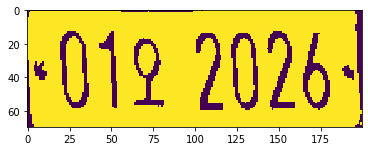

In [29]:
idx = 8
file_name = os.listdir(ROOT_PATH)[idx]
test_image = my_cv_read(os.path.join(ROOT_PATH, file_name))
print("test image", end = " ")
version = version_classifier(test_image)
if version ==0:
    print("옛날 번호판")
else:
    print("신식 번호판")
plt.imshow(test_image)
plt.show()

In [30]:
number_plate = []

number_model.eval()
hangeul_model.eval()
with torch.no_grad():
    cropped_images = crop_image(test_image)
    for image in cropped_images[:6]:
        resized_number =cv2.resize(image, (32,32)).reshape(1,1,32,32)
        resized_number = torch.from_numpy(resized_number).float().to(device)
        number_plate.append(torch.max(number_model(resized_number), 1)[1].cpu().detach().numpy()[0])
    resized_hangeul = cv2.resize(cropped_images[6], (32,32)).reshape(1,1,32,32)
    resized_hangeul = torch.from_numpy(resized_hangeul).float().to(device)
    hangeul = idx_to_hangeul[torch.max(hangeul_model(resized_hangeul), 1)[1].cpu().detach().numpy()[0]]
    number_plate.insert(2, hangeul)
print("번호판 : ","".join(map(str, number_plate)))

신식 번호판
번호판 :  07오2026


test image 옛날 번호판


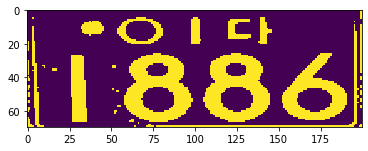

옛날 번호판
번호판 :  01다1886



test image 옛날 번호판


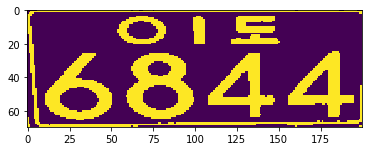

옛날 번호판
번호판 :  01도6844



test image 신식 번호판


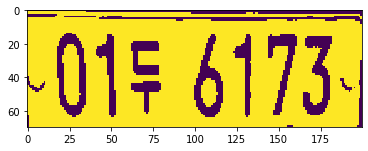

신식 번호판
번호판 :  07두6773



test image 옛날 번호판


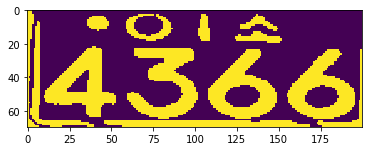

옛날 번호판
번호판 :  01소4366



test image 신식 번호판


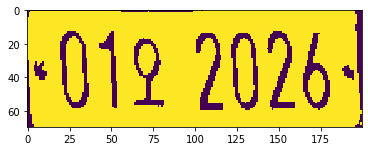

신식 번호판
번호판 :  07오2026





In [32]:
for i in [1,3,5,7,8]:
    idx = i
    file_name = os.listdir(ROOT_PATH)[idx]
    test_image = my_cv_read(os.path.join(ROOT_PATH, file_name))
    print("test image", end = " ")
    version = version_classifier(test_image)
    if version ==0:
        print("옛날 번호판")
    else:
        print("신식 번호판")
    plt.imshow(test_image)
    plt.show()
    number_plate = []

    number_model.eval()
    hangeul_model.eval()
    with torch.no_grad():
        cropped_images = crop_image(test_image)
        for image in cropped_images[:6]:
            resized_number =cv2.resize(image, (32,32)).reshape(1,1,32,32)
            resized_number = torch.from_numpy(resized_number).float().to(device)
            number_plate.append(torch.max(number_model(resized_number), 1)[1].cpu().detach().numpy()[0])
        resized_hangeul = cv2.resize(cropped_images[6], (32,32)).reshape(1,1,32,32)
        resized_hangeul = torch.from_numpy(resized_hangeul).float().to(device)
        hangeul = idx_to_hangeul[torch.max(hangeul_model(resized_hangeul), 1)[1].cpu().detach().numpy()[0]]
        number_plate.insert(2, hangeul)
    print("번호판 : ","".join(map(str, number_plate)))
    print("\n\n")